# Predicting the attrition rate of bank customers

## 1. Setup 

In [30]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

%matplotlib inline

In [2]:
df = pd.read_csv('bank_customers.csv')
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


### Features:
- Surname
- CreditScore
- Geography
- Gender
- Age
- Tenure
- Balance
- NumOfProducts
- HasCrCard
- IsActiveMember
- EstimatedSalary
- Exited --> dependent variable, to be predicted.

## 2. Exploratory data analysis
Analyze the relevant features, check and fill in missing values, visualize the data. 

In [3]:
# check missing values in the dataset
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [4]:
# check the data types
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

There are no missing values or incorrect types, so I can proceed directly with the analysis.

In [5]:
# descriptive statistics
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# calculate the percentage of customers who exited
print(round(((df['Exited']==1).sum() / len(df['Exited']) * 100), 2), "% of customers left the bank.")

20.37 % of customers left the bank.


In [8]:
# check the nr of customers by gender
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

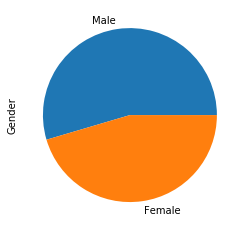

In [9]:
df['Gender'].value_counts().plot(kind='pie')

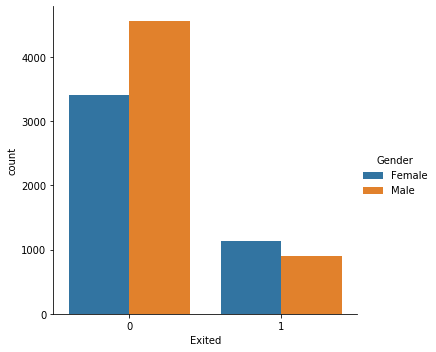

In [10]:
# plot the nr of (non-)exited customers by gender
sns.catplot(x='Exited', hue='Gender', kind="count", data=df)

In [11]:
df['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

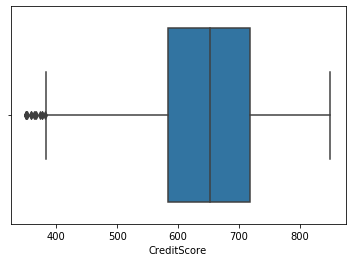

In [12]:
sns.boxplot(df['CreditScore'])

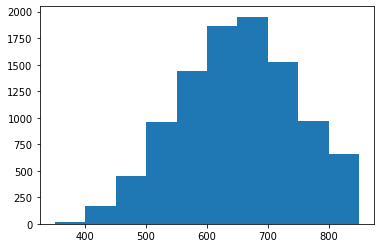

In [13]:
df['CreditScore'].hist(grid=False)

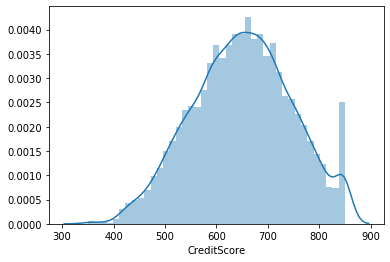

In [14]:
sns.distplot(df['CreditScore'])

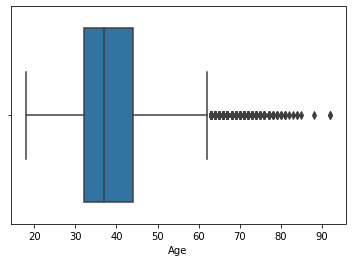

In [15]:
sns.boxplot(df['Age'])

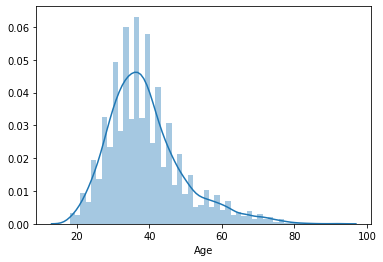

In [16]:
sns.distplot(df['Age'])

In [43]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [17]:
df['Geography'].groupby(df['Gender']).value_counts()

Gender  Geography
Female  France       2261
        Germany      1193
        Spain        1089
Male    France       2753
        Spain        1388
        Germany      1316
Name: Geography, dtype: int64

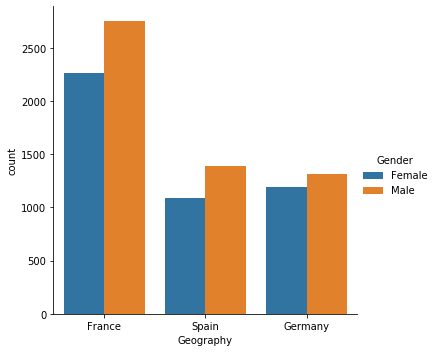

In [18]:
sns.catplot(x='Geography', hue='Gender', kind="count", data=df)

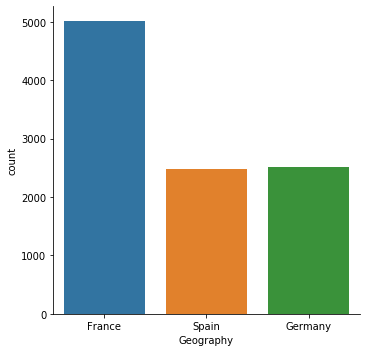

In [19]:
sns.catplot(x='Geography', kind="count", data=df)

### EDA findings:
- The average credit score of bank customers is 650, and it ranges from 350 to 850. However, the values below 370 are outliers.
- The average age is 38 years old, and it ranges from 18 years to 92 years.
- There are more male customers than female. From the customers who left the bank, most are female.
- Most customers are based in France, followed by Germany and Spain. This order applies to the number of female customers who left the bank, but more male customers from Spain than from Germany left the bank.

## 3. Feature Engineering
Wrangling and encoding the features for the following classification models.

In [20]:
# check which columns are strings
(df.dtypes == object)

RowNumber          False
CustomerId         False
Surname             True
CreditScore        False
Geography           True
Gender              True
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [21]:
# encode the columns Geography and Gender



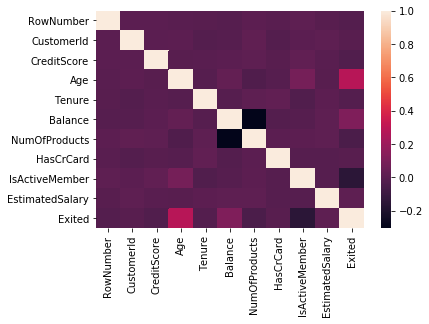

In [22]:
sns.heatmap(df.corr())

The correlation matrix reveals a correlation between:
- age and exit
- balance and exit
- member activity and age

### Splitting the data into train and test

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
#X = df[['CreditScore','NumOfProducts']]
X = df[['CreditScore','NumOfProducts','Gender']]
y = df['Exited']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 3), (2000, 3), (8000,), (2000,))

In [36]:
col_trans = ColumnTransformer([
    
    # convert gender to binary columns
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Gender']), 
    
    # normalize to 0.0 .. 1.0
    #('scaler', MinMaxScaler(), ['Culmen Length (mm)']),    
])

In [37]:
col_trans.fit(X_train)
X_trans = col_trans.transform(X_train)

In [38]:
X_trans_test = col_trans.transform(X_test)

## 3. Classification 

## 3.1. Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)
y_lr

ValueError: could not convert string to float: 'Male'

In [40]:
# evaluate the model

print(
"LR train score:", round(lr.score(X_train, y_train),3),
"\nLR test score:", round(lr.score(X_test, y_test),3),
"\nLR coefficient:", lr.coef_, 
"\nLR intercept:", lr.intercept_
)

LR train score: 0.794 
LR test score: 0.804 
LR coefficient: [[-0.00136875 -0.26926884]] 
LR intercept: [-0.05109912]


## 3.2. Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# try different estimators (default=100) and criterion ('gini' vs 'entropy')

rf = RandomForestClassifier(n_estimators=200, criterion='gini')
rf.fit(X_train, y_train)

y_rf = rf.predict(X_test)

In [ ]:
round(rf.score(X_train, y_train), 3)

## Model Evaluation

In [33]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

precision = cross_val_score(dt, X, y, cv=5, scoring='precision')
recall = cross_val_score(dt, X, y, cv=5, scoring='recall')
print("cross-validation scores DT \n", "precision: ", precision, "\n recall: ", recall)

confusion_matrix(y_true=y_test, y_pred=Y_pred)

NameError: name 'cross_val_score' is not defined